In [1]:
import lightkurve as lk
import vetting as vt

In [2]:
tic, sector = 18016577, 48  # with the period, the expected dip in sector 22 occurs in data gap, so it is not helpful

period = 35.8648067
t0 = 2630.3051774
duration = 4.6054948 / 24

In [4]:
download_dir = "../../data"

sr = lk.search_targetpixelfile(f"TIC {tic}", mission='TESS', sector=sector)
tpf_nm = sr.download(download_dir=download_dir)
tpf = tpf_nm
tpf

TessTargetPixelFile(TICID: 18016577)

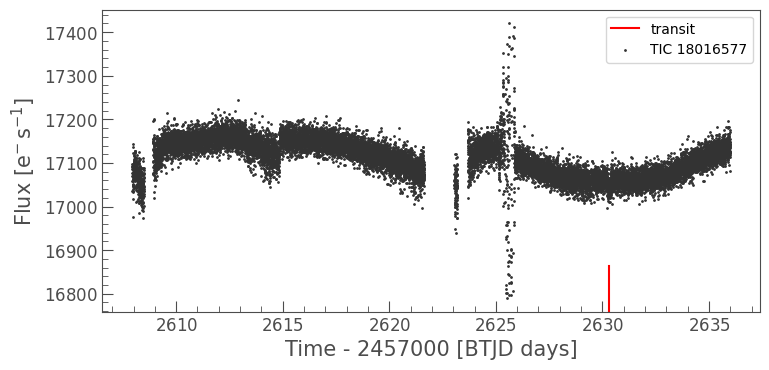

In [5]:
ax = tpf_nm.to_lightcurve().remove_outliers(sigma=7).scatter();
ax.axvline(t0, c='red', ymax=0.15, label="transit");
ax.legend();

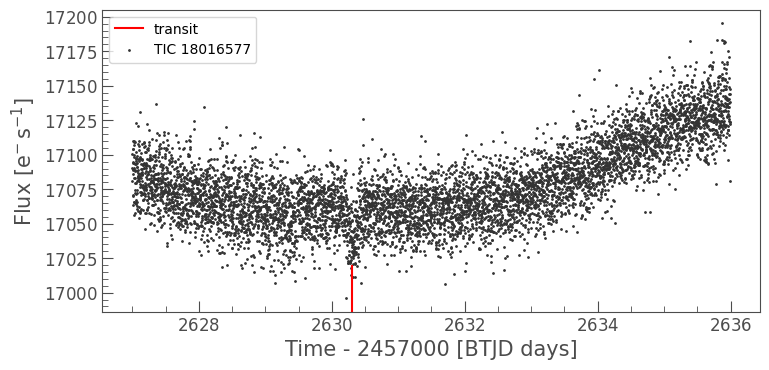

In [6]:
# mask out problematic cadence

# tpf = tpf_nm[(tpf_nm.time.value < 2624) | (2627 < tpf_nm.time.value)]
tpf = tpf_nm[2627 < tpf_nm.time.value]

ax = tpf.to_lightcurve().remove_outliers(sigma=7).scatter();
ax.axvline(t0, c='red', ymax=0.15, label="transit");
ax.legend();

([array([False])],
 [(0.4569610377827397,)],
 [(0.13220081626454777,)],
 [(0.7817212593009317,)],
 dict_keys(['figs', 'pvalues', 'pvalues_x', 'pvalues_y', 'centroid_offset_detected', 'lc_list', 'tpf_m_list', 'diagnostics_figs']))

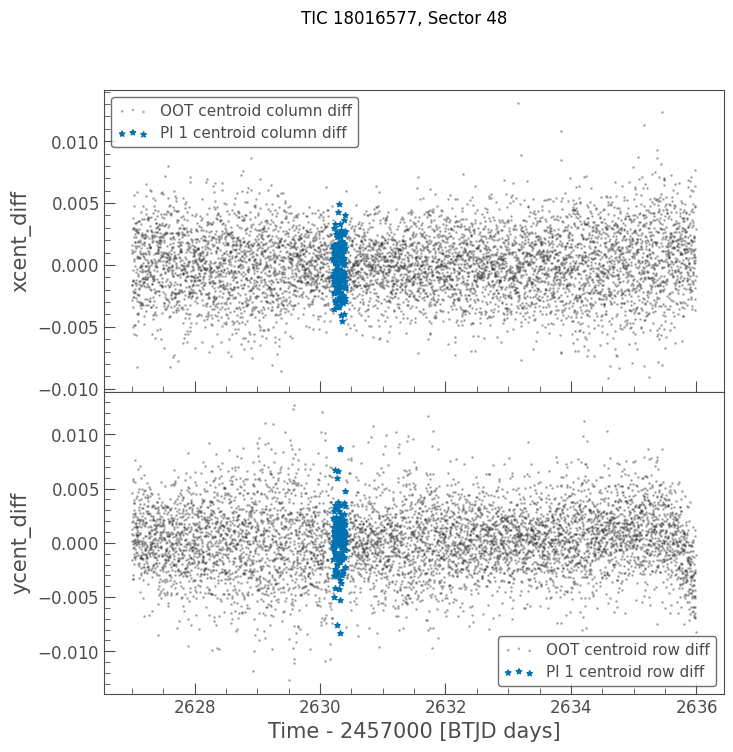

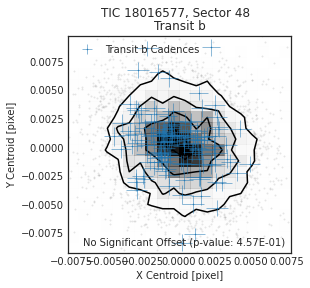

In [7]:
# if p-value is < 0.05 (5%), it means signficant centroid offset
# - distribution of centroid outside dips are not from the same population of the centroid during dips
r = vt.centroid_test(tpf, period, t0, duration, aperture_mask='pipeline',
                     kernel=20 * 15 + 1,  # default is 21
#                      nsamp=100,
                     include_diagnostics=True,
                     plot=True,                     
                    );
( 
    r['centroid_offset_detected'],
    r['pvalues'], 
    r['pvalues_x'],
    r['pvalues_y'],
    r.keys(), 
)

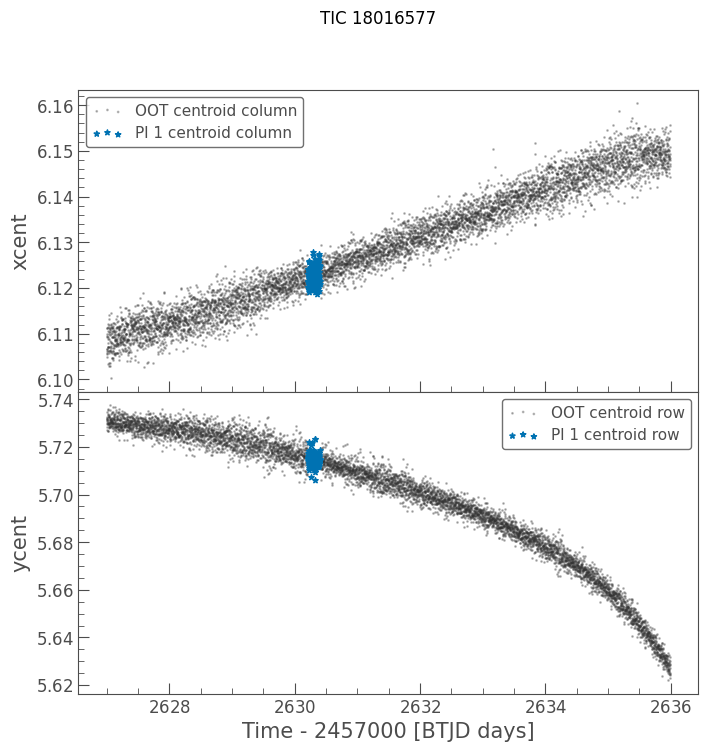

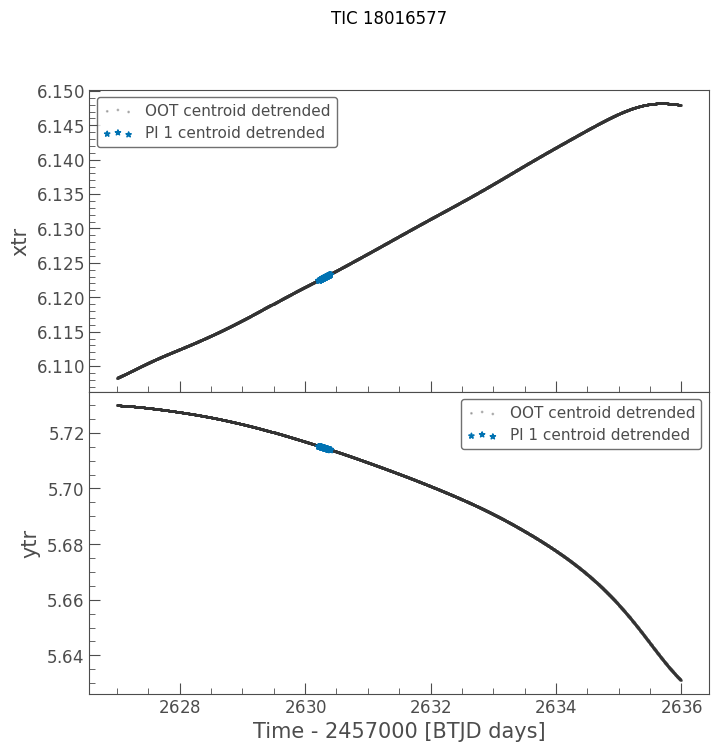

In [8]:
# plot estimated centroids / detrended centroids to check if the detrending is over/under aggressive
lc = r['lc_list'][0]
fig1 = vt.centroiding.plot_centroids_vs_time(lc, "cent");
fig2 = vt.centroiding.plot_centroids_vs_time(lc, "tr");

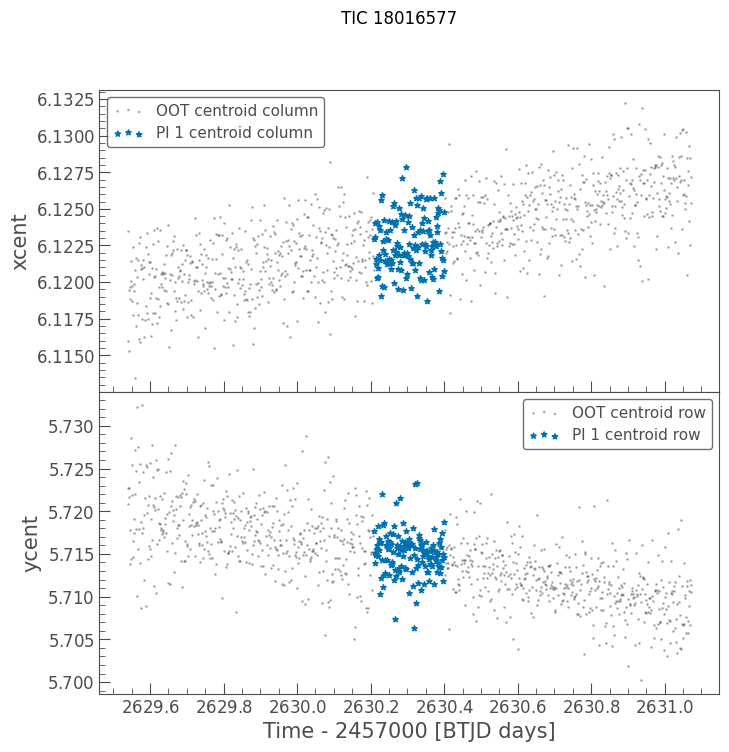

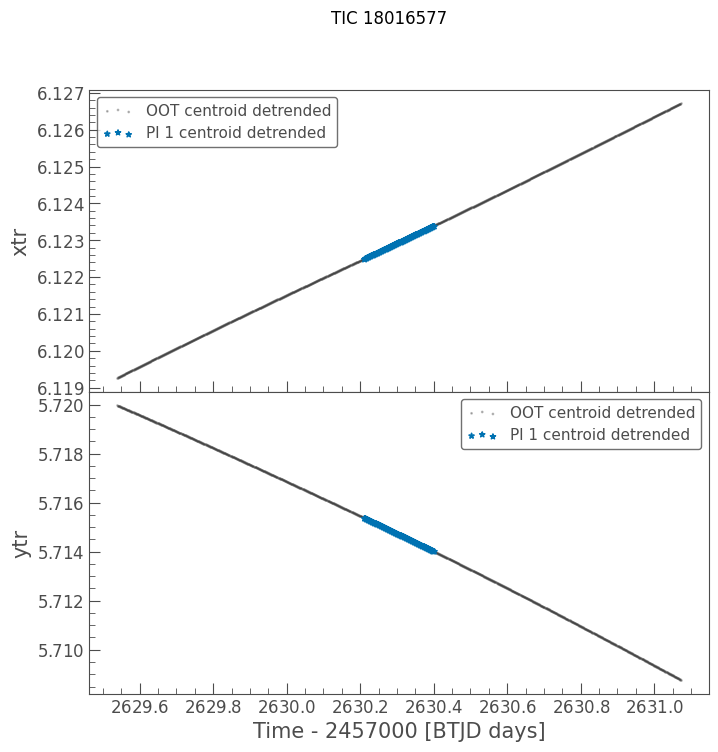

In [9]:
# zoom in to a dip to inspect again
lc_trunc = r['lc_list'][0].truncate(t0 - duration * 4, t0 + duration * 4)
fig1 = vt.centroiding.plot_centroids_vs_time(lc_trunc, "cent");
fig2 = vt.centroiding.plot_centroids_vs_time(lc_trunc, "tr");

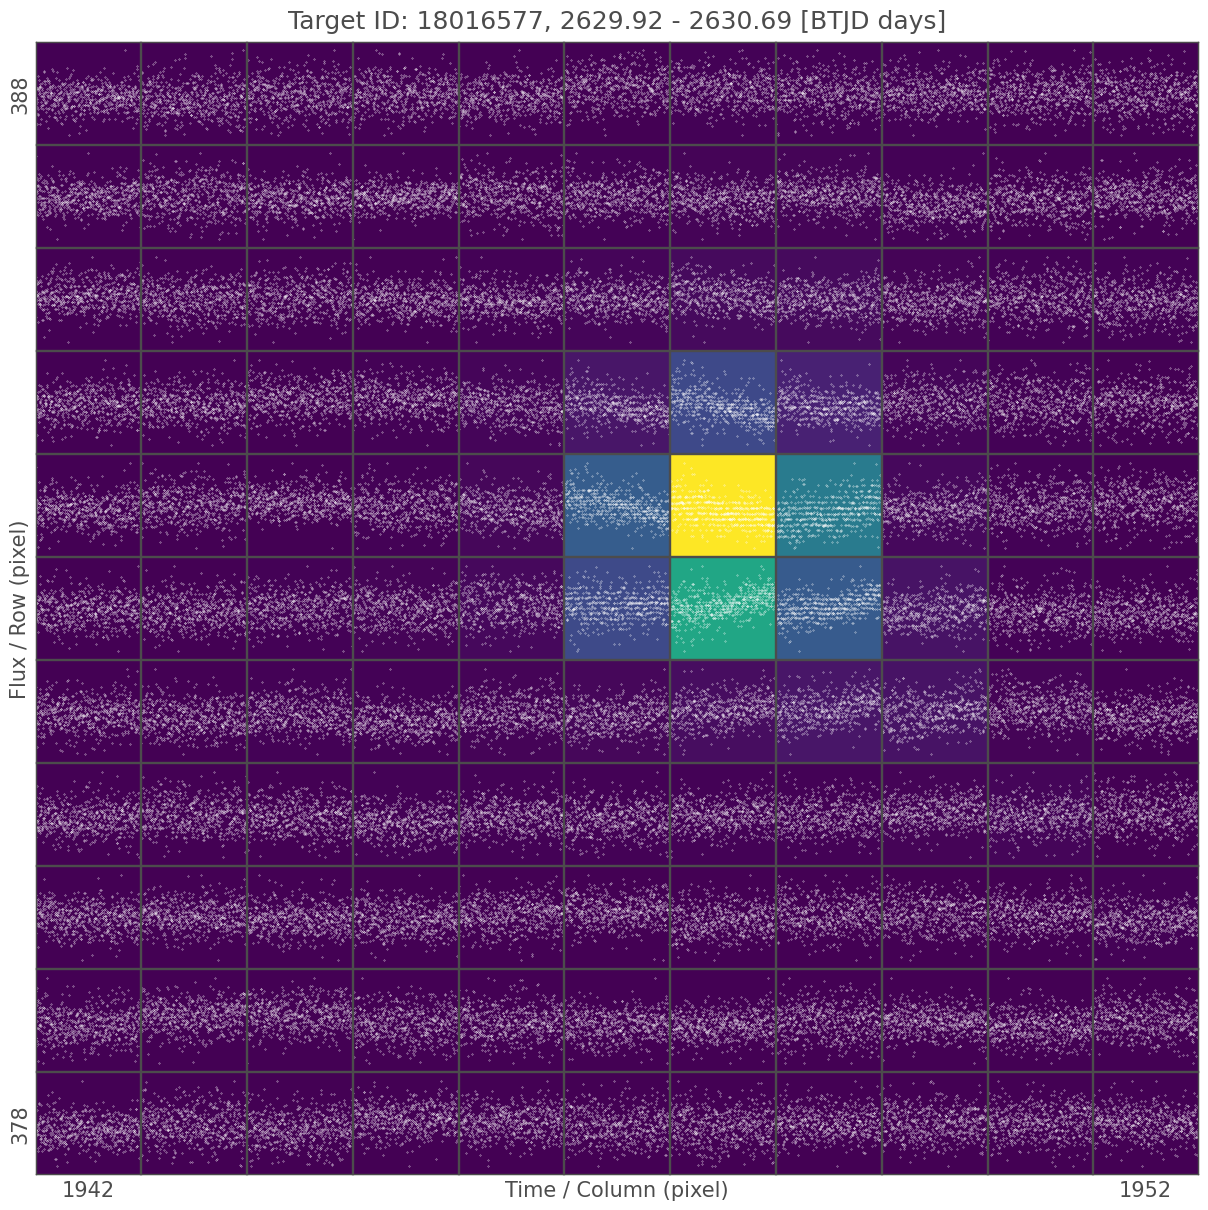

In [10]:
# per-pixel plot around the dip
tpf_trunc = tpf[(t0 - duration * 2 < tpf.time.value) & (tpf.time.value < t0 + duration * 2)]

tpf_trunc.plot_pixels(aperture='pipeline', show_flux=True);